In [1]:
# Import modules and define configurations
import numpy as np
import datetime
from datetime import date
from datetime import timedelta
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


from typing import List, Tuple
    
# data: DataFrame


sem1_start = {"month": 8, "day": 18}
sem1_end = {"month": 12, "day": 18}
sem2_start = {"month": 1, "day": 30}
sem2_end = {"month": 5, "day": 20}
        
# Set random seed for reproducibility


### Configuration

6 to 2


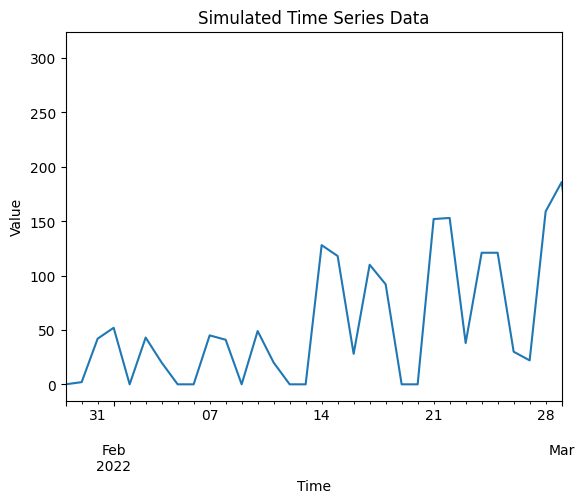

In [2]:
np.random.seed(42)
a = pd.DataFrame()
a['date']=pd.date_range(start='2022-01-29', end='2023-01-29')
data=pd.DataFrame(a['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.isocalendar().week
data['day'] = data['date'].dt.day
data['dayweek'] = data['date'].dt.weekday
data['demand'] = [0] * 366

# data generation
def generate_data(date: date) -> int:
    week = date.isocalendar()[1]
    weekday = date.weekday()
    lam = max(average + week_factor[week-1] + day_factor[weekday], 0.5)
    demand = np.random.poisson(lam=lam,size=1)[0]
    return demand


average=100
day_factor=[50, 50, -50, 50, 25, -75, -75]
week_factor=[-150, -150, -150, -150, -100, -100, -25, 0, 25, 50,
            75, 75, 50, 25, 0, 0, 25, 50,
             150, 50, -50, -150, -150, -150, -150, -150, -150, -150, -150, -150, -150, -150, -150,
             -50, -50, -25, 0, 0, 0, 50, 75, 50, 25, 0, 0, 25, 25, 0, 150, 50,
             -75, -150]

for index, row in data.iterrows():
    d = row['date']
    demand = generate_data(d)
    data.at[index, "demand"] = demand
    
data.set_index('date', inplace=True)
        
#edit here,yyyy,m,dd
start_date = date(2022,1,29)
end_date = date(2022,3,1)
print(start_date.weekday()+1, 'to', end_date.weekday()+1)

start = (start_date-date(1970,1,1)).days
end = (end_date-date(1970,1,1)).days



""" data.loc[start_date: end_date, ['demand']].plot(data['date'], data) """
data['demand'].plot()

plt.title('Simulated Time Series Data')
plt.xlim(start,end)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

#plt.xlim(19359,19724)
#plt.xlim(start,end)
plt.show() 


In [3]:

def forecast1(today: date, data: DataFrame) -> int:
    """
        The number of study room opened today is based on yesterday data.
    """
    yesterday: date = today - timedelta(days=1)
    yesterday_pd = pd.to_datetime(yesterday)
    expectation: int = data.loc[yesterday_pd, "demand"]

    return expectation
    
    

In [4]:
def forecast2(today: date, data: DataFrame) -> int:
    """
        The number of study room opened this week is based on lask week data mean.
    """
    # all the dates data that is included in calculating the expectation for today
    accountables: List(int) = []
    
    weekday: int = today.weekday()
    date_back: date = today - timedelta(days=weekday+1)
    for i in range(7):
        date = date_back - timedelta(days=i)
        date_pd = pd.to_datetime(date)
        accountables.append(data.loc[date_pd, "demand"])
        
    expectation = round(np.mean(accountables))
    return expectation

In [5]:
def forecast3(today: date, data: DataFrame) -> int:
    """
        The number of study room opened this month is based on last month data mean.
    """
    last_month: int = find_previous_month(today.month)
    year: int = today.year-1 if last_month == 12 else today.year
    first_day = date(year, last_month, 1)
    
    accountables: List(int) = []
    d = first_day
    this_month = d.month
    while d.month == this_month:
        date_pd = pd.to_datetime(d)
        accountables.append(data.loc[date_pd, "demand"])
        d = d + timedelta(days=1)
    expectation: int = round(np.mean(accountables))

    return expectation

def find_previous_month(val: int) -> int:
    l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    index = l.index(val)
    if index == 0:
        prev_ind = len(l) - 1
    else:
        prev_ind = index - 1
        
    return l[prev_ind]

In [6]:
def simple(today: date, d: DataFrame) -> int:
    # always return the mean value of the past year data
    
    return round(data['demand'].mean())

In [7]:
# Fit the GLM poisson forecast model

GLM_model = smf.glm(formula='demand ~ C(month)', data=data, 
                    family=sm.families.Poisson(link=sm.families.links.log())).fit()

In [8]:
def forecast4(today: date, data: DataFrame) -> int:
    """
    
        Determine number to open based on Poisson Regression Model with trend components and month variables.
    """
    new_data = {"month": today.month}
    
    predicted_demand = round(GLM_model.predict(new_data)[0])
    
    return predicted_demand
    

### Simulation Process
This model simulates the demand for study rooms in a university, and how different policy to open study rooms would affect university's profit. 

In [9]:

# decision variables
buffer: int = 0                             # number to open more than demand to ensure that demand is always met
forecast_method: int = 1                    # which forecast method to adopt

# tuition variables
tuition_per_student: float = 160000               # how much school would gain from one student increase next 
α: float = 0.01                                 # decrease in next year student per demand not satified

# Room cost variables
daily_room_cost: float = 200                  # how much opening one study room for a day would cost

# Begin the simulation process for a year beginning from the second semester of 2022/2023
start_date = date(2023, 1, 30)
end_date = date(2024, 1, 29)


# return a forecast demand for the date
def forecast(date, data) -> int:
    if forecast_method == 1:
        return forecast1(date, data)
    elif forecast_method == 2:
        return forecast2(date, data)
    elif forecast_method == 3:
        return forecast3(date, data)
    elif forecast_method == 4:
        return forecast4(date, data)
    elif forecast_method == 0:
        return simple(date, data)
    else:
        raise ValueError("Invalid forecast method")

def simulate():
    global data
    np.random.seed(12)
    current_date = start_date
    simulation = []
    total_cost = 0
    simu_data = data.copy()
    while current_date <= end_date:
        real_time_demand = generate_data(current_date)
        predicted = forecast(current_date, simu_data)
        simu_data.loc[pd.to_datetime(current_date), "demand"] = real_time_demand
        
        number_to_open = predicted + buffer
        shortage = max(real_time_demand-number_to_open, 0)
        over_supply = max(number_to_open-real_time_demand, 0)
        
        # Loss due to unsatisfied students
        tuition_loss = (shortage * α * tuition_per_student)
        
        # Study room cost
        study_room_cost = daily_room_cost * number_to_open
        
        cost = tuition_loss + study_room_cost
        total_cost += cost
        
        simulation.append({"date": pd.to_datetime(current_date), "demand": real_time_demand, "predict": predicted,
                           "opened": number_to_open, "cost": cost, "tuition loss": tuition_loss,
                           "study room cost": study_room_cost, "unsatisfied": shortage,
                           "tuition loss": tuition_loss, "study room cost": study_room_cost,
                           "oversupply": over_supply})
        current_date = current_date + timedelta(days=1)
        
    simulation = DataFrame(simulation)
    simulation.set_index('date', inplace=True)
    mean_daily_cost = total_cost / ((end_date-start_date).days + 1)
    print(f"mean cost per day is {mean_daily_cost:.2f}")
    return simulation



mean cost per day is 50799.45


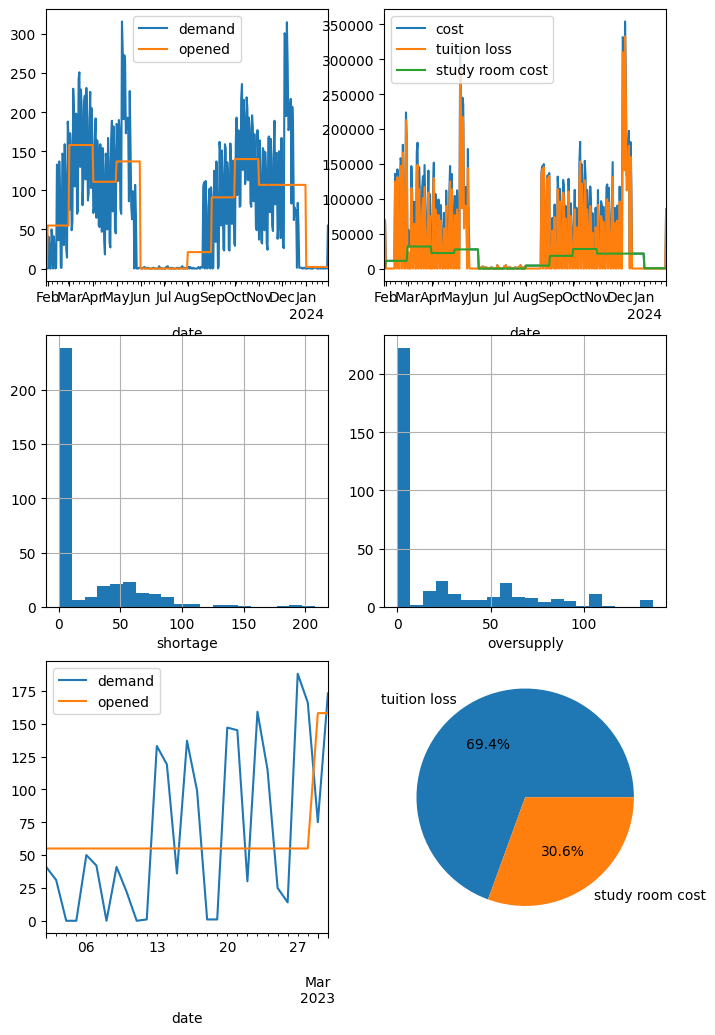

mean shortage: 22.05
mean oversupply: 22.26


In [10]:
# See how different forecast method would affect the cost
forecast_method = 4
simulation = simulate()
total_tui_loss = simulation['tuition loss'].sum()
total_study_room_cost = simulation['study room cost'].sum()
sizes = [total_tui_loss, total_study_room_cost]
labels = ['tuition loss', 'study room cost']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))
simulation[["demand", "opened"]].plot(ax=axes[0, 0])
simulation[["cost", "tuition loss", "study room cost"]].plot(ax=axes[0, 1])
simulation.loc['2023-02-02':'2023-03-02', ["demand", "opened"]].plot(ax=axes[2, 0])
simulation["unsatisfied"].hist(ax=axes[1, 0], bins=20)
simulation["oversupply"].hist(ax=axes[1, 1], bins=20)
axes[1, 0].set_xlabel('shortage')
axes[1, 1].set_xlabel('oversupply')
axes[2, 1].pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()
print("mean shortage:", round(simulation["unsatisfied"].mean(), 2))
print("mean oversupply:",round(simulation["oversupply"].mean(), 2))

mean cost per day is 55978.08


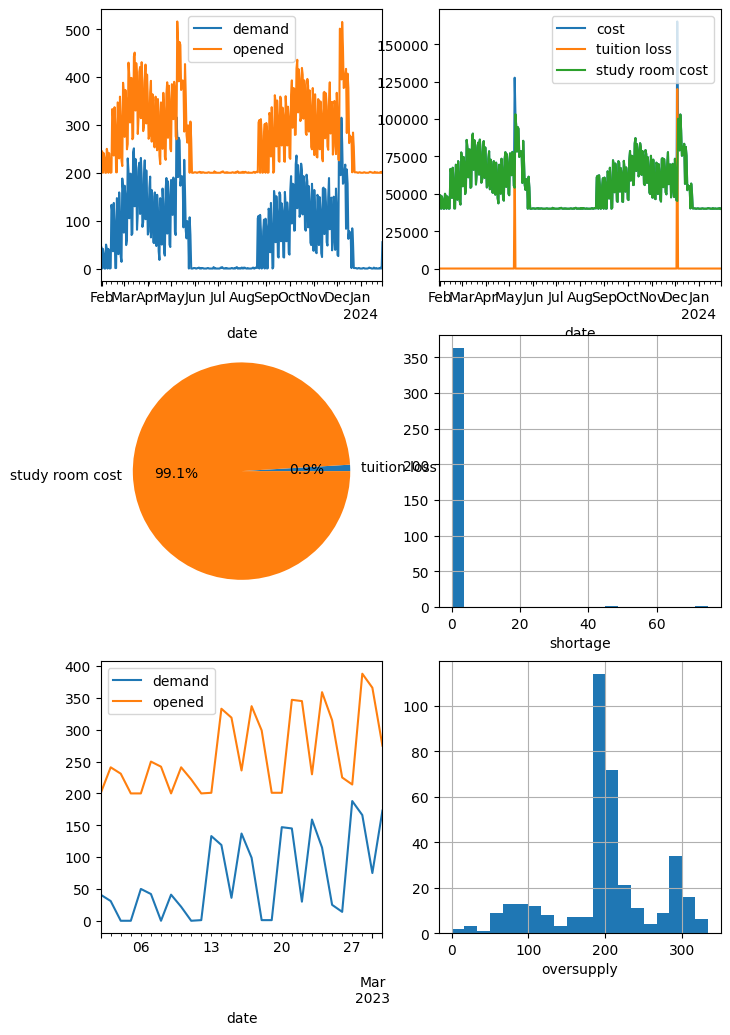

mean shortage: 0.33
mean oversupply: 200.18


In [11]:
# Demand first strategy
# Increase the buffer to ensure demands are always met
forecast_method = 1
buffer = 200
simulation = simulate()
total_tui_loss = simulation['tuition loss'].sum()
total_study_room_cost = simulation['study room cost'].sum()
sizes = [total_tui_loss, total_study_room_cost]
labels = ['tuition loss', 'study room cost']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))
simulation[["demand", "opened"]].plot(ax=axes[0, 0])
simulation[["cost", "tuition loss", "study room cost"]].plot(ax=axes[0, 1])
simulation.loc['2023-02-02':'2023-03-02', ["demand", "opened"]].plot(ax=axes[2, 0])
simulation["unsatisfied"].hist(ax=axes[1, 1], bins=20)
simulation["oversupply"].hist(ax=axes[2, 1], bins=20)
axes[1, 1].set_xlabel('shortage')
axes[2, 1].set_xlabel('oversupply')
axes[1, 0].pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()
print("mean shortage:", round(simulation["unsatisfied"].mean(), 2))
print("mean oversupply:",round(simulation["oversupply"].mean(), 2))

mean cost per day is 25682.96


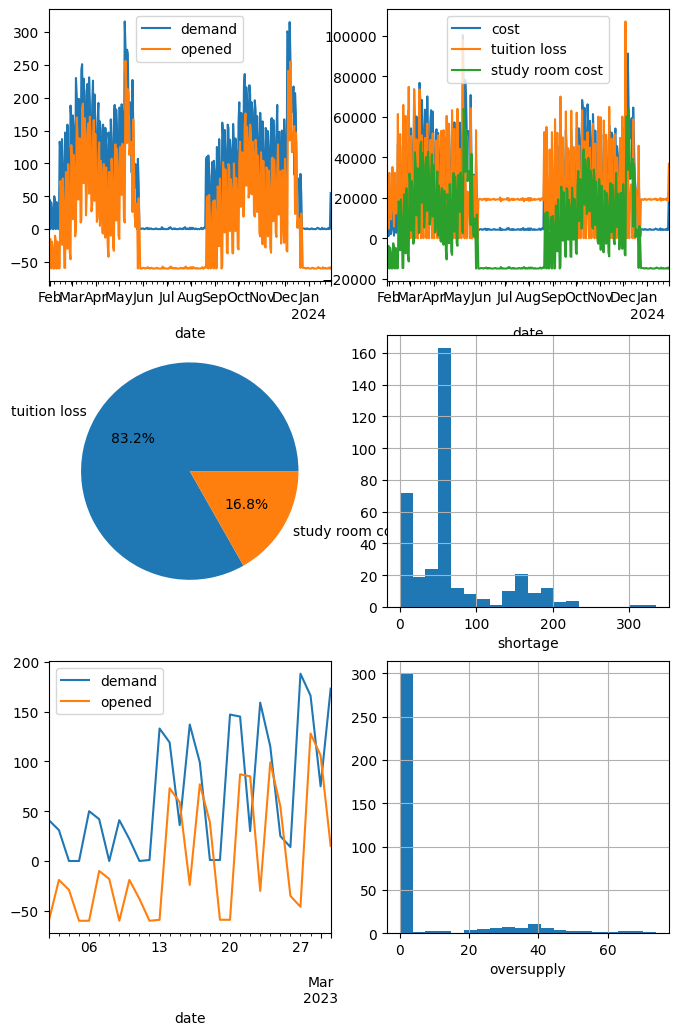

mean shortage: 66.79
mean oversupply: 6.64


In [35]:
# Explore how different tuition and daily cost per study room affect the process
tuition_per_student = 32000
daily_room_cost = 250
buffer = -60
forecast_method = 1

simulation = simulate()
total_tui_loss = simulation['tuition loss'].sum()
total_study_room_cost = simulation['study room cost'].sum()
sizes = [total_tui_loss, total_study_room_cost]
labels = ['tuition loss', 'study room cost']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))
simulation[["demand", "opened"]].plot(ax=axes[0, 0])
simulation[["cost", "tuition loss", "study room cost"]].plot(ax=axes[0, 1])
simulation.loc['2023-02-02':'2023-03-02', ["demand", "opened"]].plot(ax=axes[2, 0])
simulation["unsatisfied"].hist(ax=axes[1, 1], bins=20)
simulation["oversupply"].hist(ax=axes[2, 1], bins=20)
axes[1, 1].set_xlabel('shortage')
axes[2, 1].set_xlabel('oversupply')
axes[1, 0].pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()
print("mean shortage:", round(simulation["unsatisfied"].mean(), 2))
print("mean oversupply:",round(simulation["oversupply"].mean(), 2))